<a href="https://colab.research.google.com/github/Kiichiro-T/python/blob/main/kalman_filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

状態方程式
$$x_t=F_t x_{t-1}+G_t v_t$$
$$v_t - N(0,Q_t)$$
観測方程式
$$y_t=H_t x_t + w_t$$
$$w_t - N(0,R_t)$$

In [ ]:
# フィルタ
def kalman_filter(x_p, y, V_p, H, R):
  A = V_p.dot(H.T)
  B = H.dot(V_p).dot(H.T)+R
  K = np.linalg.solve(A, B)
  x_f = x_p + K * (y - H.dot(x_p))
  V_f = (np.identity(H.ndim) - K * H).dot(V_p)

  return x_f, V_f

In [ ]:
# 予測
def kalman_prediction(x_f, V_f, F, G, Q):
  x_p = F.dot(x_f)
  V_p = F.dot(V_f).dot(F.T) + G.dot(Q).dot(G.T)

  return x_p, V_p

In [ ]:
np.random.seed(1)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


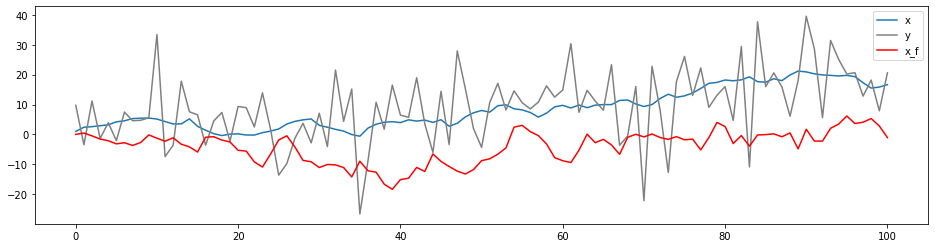

In [ ]:
# ローカルレベルモデル
F = 1
G = 1
H = 1
Q = 1
R = 10
T = 100

x = np.zeros(T+1)
y = np.zeros(T+1)
x_f1 = np.zeros(T+1)
x_f2 = np.zeros(T+1)
V_f1 = np.zeros(T+1)
V_f2 = np.zeros(T+1)
x_p = np.zeros(T+1)
V_p = np.zeros(T+1)
x_s = np.zeros(T+1)
V_s = np.zeros(T+1)

x[0] = np.random.normal(loc=0, scale=1)
y[0] = x[0] + np.random.normal(loc=0, scale=10)

for t in range(1, T+1):
  # 真の値
  x[t] = x[t-1] + np.random.normal(loc=0, scale=1)

  # 観測
  y[t] = H * x[t] + np.random.normal(loc=0, scale=10)

  # 予測
  x_p[t] = F * x_f1[t-1]
  V_p[t] = F * V_f1[t-1] * F + G * Q * G

  # フィルタ
  K = V_p[t] * H / (H * V_p[t] * H + R)
  x_f1[t] = x_p[t] + K * (y[t] - H * x_p[t])
  V_f1[t] = (1 - K * H) * V_p[t]

fig, ax = plt.subplots(figsize=(16, 4))
sns.lineplot(np.arange(T+1), x, ax=ax, label='x')
sns.lineplot(np.arange(T+1), y, ax=ax, color='gray', label='y')
sns.lineplot(np.arange(T+1), x_f, ax=ax, color='red', label='x_f')
# ax.set_title('simulation')
ax.legend()
plt.show()

観測誤差57.98603505019439
カルマンフィルタによる推定誤差3.41677175368638


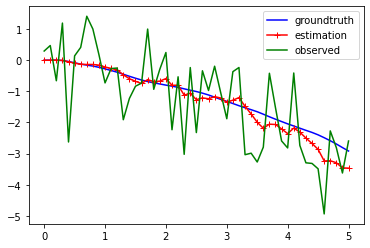

In [ ]:
# 参考：　https://qiita.com/harmegiddo/items/ddd33f40d5e368a210df
# generate norm
def norm(_loc=0.0, _scale=1.0, _size=(1)):
    return random.normal(_loc, _scale, _size) 

####################################################################
###########################  初期値の設定  ##########################
####################################################################
# 時刻
global_time = 0
# t+1の刻み設定
dt=0.1
# 計算回数
calc_num = 50
end_time = calc_num * dt 
# 正規分布の発生に関するパラメータ
mean_a = 0
sigma_a = 1
mean_z = 0
sigma_z = 1
# 単位行列
I = np.matrix([[1 , 0],
               [0, 1]])
# Plot用
ground_truth_position=[]
observed_position=[]
estimate_position=[]
time_series=[]

##########       状態方程式        ##########
# トロッコの位置と速度: [位置, 加速度]
x_k = np.matrix([ 
                [0],
                [0]
            ]) 

x_k_true = x_k
x_k_k = x_k
# 運動方程式 [位置+(加速度*時間), 加速度]
F = np.matrix([ 
                [1, dt],
                [0, 1]
            ]) 
# 時間遷移に関する雑音モデルの行列 (0平均かつQの正規分布に従う)
G = np.matrix([
                [(dt**2) / 2],
                [dt]
            ])

##########       観測方程式        ##########
# 誤差行列
p_k = np.matrix([
                [0, 0],
                [0, 0]
             ])
p_k_k = p_k
# 位置のみを線形写像する観測モデル
H = np.matrix([
                1,
                0
             ])
# cov(Gw_k) = (sigma_a)^2 * (G)(G^T): 共分散
Q = (sigma_a**2) * G * G.T
# R = E(v_k*(v_k)^t) = (sigma_z)^2: ?
R = sigma_z**2


####################################################################
###########################  計算スタート  ##########################
####################################################################
while global_time < end_time:

    ##########       観測        ##########

    # v_k: 観測誤差 (偶然誤差)
    v_k = norm(mean_z, sigma_z)
    # z_k = Hx_k + v_k: トロッコの位置をセンサで観測する
    # z_k = H * x_k_true + v_k
    z_k = H * x_k_true + v_k
    observed_position.append(z_k.tolist()[0][0])

    ##########       予測        ##########
    # w_k = [a_k]: トロッコの加速度(誤差混み)
    w_k = norm(mean_a, sigma_a)
    # Fx_{k-1} + Gw_k: 現時刻における予測推定値
    x_k = (F * x_k_k) + (G * w_k)

    ## 真値(次の位置)
    # Fx_{k-1} + Gw_k: （補正しない）現時刻における予測推定値
    x_k_true = (F * x_k_true) + (G * w_k)
    ground_truth_position.append(x_k_true.tolist()[0][0])

    ##########     補正と更新     ##########
    # F * P_{k-1} * F^T + G_k * Q_k * (G_k)^T: 現時刻における予測誤差行列
    p_k = F * p_k_k * F.T + Q
    # R + H * P_k * H^T: 観測残差の共分散
    S_k = (H * p_k) * H.T + R
    # P_k * H^T * S^-1: 最適カルマンゲイン
    K_k = p_k * H.T * S_k.I
    # z_k - H * x_k: 観測残差
    e_k = z_k - H * x_k
    # x_k + K_k * e_k: 位置の補正
    x_k_k = x_k + K_k * e_k
    estimate_position.append(x_k_k.tolist()[0][0])
    # (I - K_k * H) * p_k_k: 更新された誤差の共分散
    p_k_k = (I - K_k * H) * p_k



    ##########    タイムカウント    ##########
    time_series.append(global_time)
    global_time += dt


MSE = np.sum((np.array(ground_truth_position)-np.array(observed_position))**2)
print("観測誤差"+str(MSE))
MSE = np.sum((np.array(ground_truth_position)-np.array(estimate_position))**2)
print("カルマンフィルタによる推定誤差"+str(MSE))

plt.plot(time_series, ground_truth_position, color="blue", marker="", label="groundtruth")
plt.plot(time_series, estimate_position, color="red", marker="+", label="estimation")
plt.plot(time_series, observed_position, color="green", marker="", label="observed")
plt.legend()
plt.show()